# Task 8 (Extended). Practical analysis of advanced algorithms

Goal

Practical analysis of advanced algorithms

In [1]:
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
import time
from scipy.optimize import curve_fit

In [9]:
#Our graph is considered to be sparse, only 500 edges when it can be 4950
vertices = 100
edges = 500
max_weight = 100

# Generating adjacency matrix
def generate_adjacency_matrix(vertices, edges, max_weight):
    random.seed(1) # with this random seed no negative cycles are present
    matrix = np.zeros((vertices, vertices), dtype=int)
    count = 0
    while count < edges:
        i, j = random.sample(range(vertices), 2)
        if matrix[i][j] == 0 and i != j:
            weight = random.randint(-5, max_weight) # Edges with negative weights are present, but not too many
            matrix[i][j] = weight
            count += 1
    return matrix

In [10]:
matrix = generate_adjacency_matrix(vertices, edges, max_weight)
print(f'Shape: {matrix.shape}, weight sum: {np.sum(matrix)}')

Shape: (100, 100), weight sum: 23926


In [11]:
# Edges with negative weights 
for i in range(len(matrix)):
    for j in range(len(matrix[i])):
        if matrix[i][j] < 0:
            print(f"Edge (src,dest): ({i}, {j}), Value: {matrix[i][j]}")

Edge (src,dest): (1, 71), Value: -1
Edge (src,dest): (2, 28), Value: -3
Edge (src,dest): (9, 10), Value: -3
Edge (src,dest): (26, 71), Value: -5
Edge (src,dest): (27, 87), Value: -1
Edge (src,dest): (37, 80), Value: -3
Edge (src,dest): (40, 3), Value: -3
Edge (src,dest): (40, 5), Value: -2
Edge (src,dest): (50, 18), Value: -1
Edge (src,dest): (50, 75), Value: -1
Edge (src,dest): (58, 76), Value: -2
Edge (src,dest): (62, 93), Value: -2
Edge (src,dest): (64, 21), Value: -2
Edge (src,dest): (66, 64), Value: -4
Edge (src,dest): (74, 2), Value: -2
Edge (src,dest): (77, 93), Value: -5
Edge (src,dest): (90, 57), Value: -2
Edge (src,dest): (92, 23), Value: -5
Edge (src,dest): (93, 9), Value: -3
Edge (src,dest): (95, 71), Value: -5
Edge (src,dest): (99, 77), Value: -4


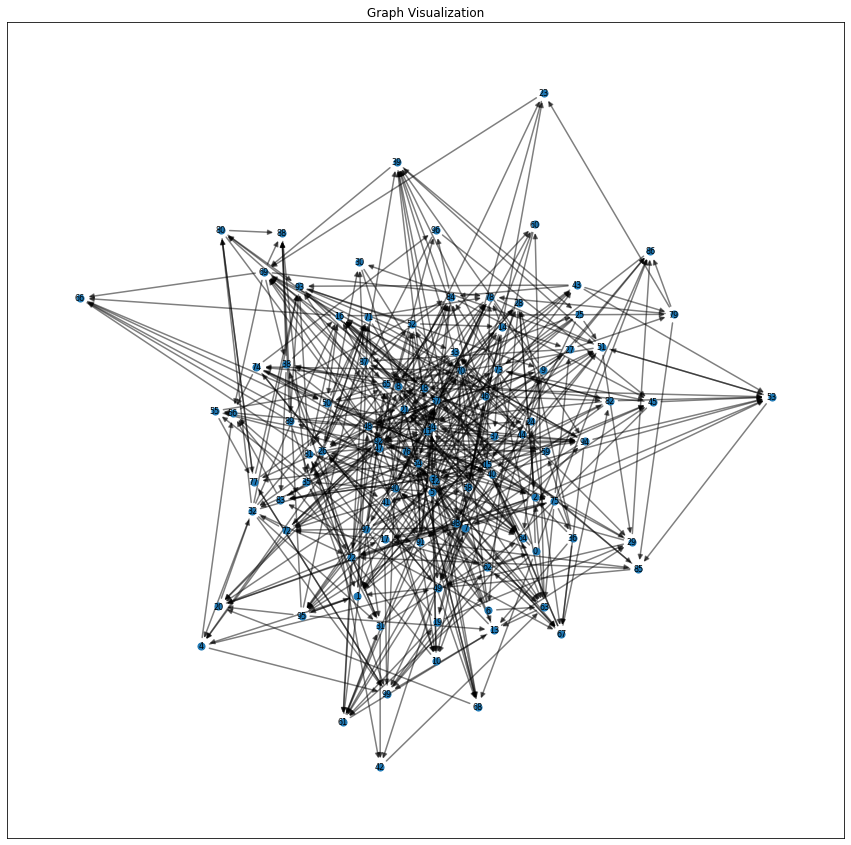

In [12]:
def matrix_to_graph(matrix):
    G = nx.DiGraph()
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if matrix[i][j]:
                G.add_edge(i, j, weight=matrix[i][j])
    return G

G = matrix_to_graph(matrix)

plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=50)
nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Graph Visualization")
plt.show()

# Floyd-Warshall and Johnson’s algorithms

In [13]:
# Floyd-Warshall algorithm
shortest_paths_fw = nx.floyd_warshall(G, weight='weight')

In [14]:
# Johnson’s algorithm
shortest_paths_johnson = dict(nx.johnson(G, weight='weight'))

Choose 3 random pairs of vertices and see if algorithms produce the same results

In [15]:
# Floyd-Warshall algo

def reconstruct_path(pred, source, target):
    if source == target:
        return [source]
    
    path = []
    while target is not None:
        path.append(target)
        target = pred[source].get(target)
    if not path or path[-1] != source:
        return None
    path.reverse()
    return path
    
# Johnson's algo
def compute_path_weight(graph, path):
    weight = 0
    for i in range(len(path) - 1):
        weight += graph[path[i]][path[i+1]]['weight']
    return weight

# General
pairs = [(random.randint(0, vertices-1), random.randint(0, vertices-1)) for _ in range(3)]
results = []

pred_fw, _ = nx.floyd_warshall_predecessor_and_distance(G, weight='weight')


for src, dest in pairs:
    # Floyd-Warshall Path & Cost
    path_fw = reconstruct_path(pred_fw, src, dest)
    cost_fw = shortest_paths_fw[src][dest] if path_fw else float('inf')
    
    # Johnson's Path & Cost
    path_johnson = shortest_paths_johnson[src].get(dest)
    cost_johnson = compute_path_weight(G, path_johnson) if path_johnson else float('inf')
    
    results.append({
        'pair': (src, dest),
        'Floyd-Warshall': {'path': path_fw, 'cost': cost_fw},
        'Johnson': {'path': path_johnson, 'cost': cost_johnson}
    })

# Results    
for res in results:
    print(f"Vertices: {res['pair']}")
    print(f"Floyd-Warshall: Path - {res['Floyd-Warshall']['path']}, Cost - {res['Floyd-Warshall']['cost']}")
    print(f"Johnson: Path - {res['Johnson']['path']}, Cost - {res['Johnson']['cost']}")
    print("----" * 10)

Vertices: (50, 14)
Floyd-Warshall: Path - [50, 34, 97, 58, 14], Cost - 113
Johnson: Path - [50, 34, 97, 58, 14], Cost - 113
----------------------------------------
Vertices: (77, 61)
Floyd-Warshall: Path - [77, 93, 9, 27, 87, 61], Cost - 91
Johnson: Path - [77, 93, 9, 27, 87, 61], Cost - 91
----------------------------------------
Vertices: (13, 19)
Floyd-Warshall: Path - [13, 99, 19], Cost - 28
Johnson: Path - [13, 99, 19], Cost - 28
----------------------------------------


They do produce exactly the same results

# Analyze in terms of time complexity

In [16]:
# Generating adjacency matrix
def generate_adjacency_matrix_positive(vertices, edges, max_weight):
    random.seed(3) # with this random seed no negative cycles are present
    matrix = np.zeros((vertices, vertices), dtype=int)
    count = 0
    while count < edges:
        i, j = random.sample(range(vertices), 2)
        if matrix[i][j] == 0 and i != j:
            weight = random.randint(-1, max_weight)
            matrix[i][j] = weight
            count += 1
    return matrix

In [17]:
# Theoretical time complexities: 
def fw_theoretical(n, a):
    return a * n**3

def johnson_theoretical(n, b, c):
    # V * E = V * V * (V-1) * 0.5 * 0.1 ~= c * V^3
    return b * n**2 * np.log(n) + c * n **3

In [18]:
def time_taken_for_fw(G_t):
    start = time.time()
    nx.floyd_warshall(G_t)
    end = time.time()
    return end - start

def time_taken_for_johnson(graph):
    start = time.time()
    nx.johnson(G_t)
    end = time.time()
    return end - start

sizes = []
time_fw = []
time_johnson = []

for size in range(20, 110, 2):
    vertices = size
    edges = round(((vertices*(vertices-1))/2)*0.1) #creating sparse graph
    matrix_t = generate_adjacency_matrix_positive(vertices, edges, max_weight)
    G_t = matrix_to_graph(matrix_t)
    sizes.append(size)
    time_fw.append(time_taken_for_fw(G_t))
    time_johnson.append(time_taken_for_johnson(G_t))

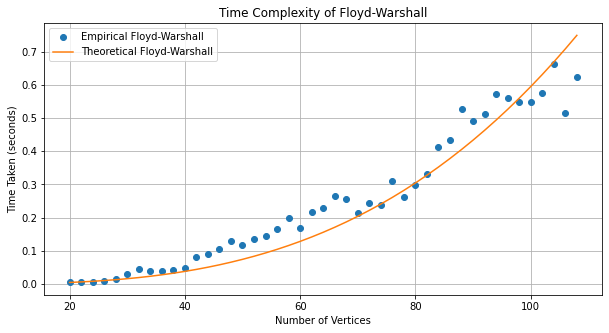

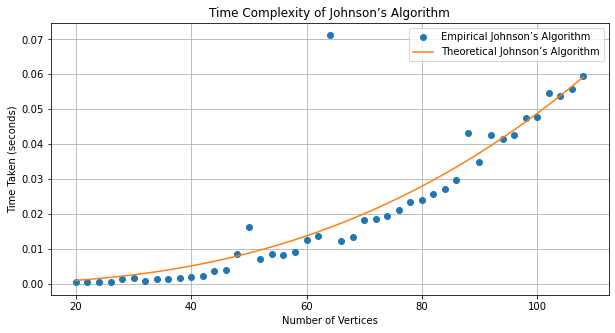

In [19]:
# Fitting curves
params_fw, _ = curve_fit(fw_theoretical, sizes, time_fw)
params_johnson, _ = curve_fit(johnson_theoretical, sizes, time_johnson)

# Plot for Floyd-Warshall
plt.figure(figsize=(10, 5))
plt.plot(sizes, time_fw, 'o', label='Empirical Floyd-Warshall')
plt.plot(sizes, fw_theoretical(np.array(sizes), *params_fw), '-', label='Theoretical Floyd-Warshall')
plt.xlabel('Number of Vertices')
plt.ylabel('Time Taken (seconds)')
plt.title('Time Complexity of Floyd-Warshall')
plt.legend()
plt.grid(True)
plt.show()

# Plot for Johnson's
plt.figure(figsize=(10, 5))
plt.plot(sizes, time_johnson, 'o', label='Empirical Johnson’s Algorithm')
plt.plot(sizes, johnson_theoretical(np.array(sizes), *params_johnson), '-', label='Theoretical Johnson’s Algorithm')
plt.xlabel('Number of Vertices')
plt.ylabel('Time Taken (seconds)')
plt.title('Time Complexity of Johnson’s Algorithm')
plt.legend()
plt.grid(True)
plt.show()

# Analyze in terms of space complexity

In [ ]:
# This part is optional as it doesnt really work well

In [ ]:
#pip install memory-profiler

In [20]:
# Theoretical space complexities: 
def space_theoretical(n, a):
    return a * n**2

In [21]:
from memory_profiler import memory_usage
from tqdm import tqdm
import gc

In [22]:
gc.disable()
def space_taken_for_fw(G_t):
    base_memory = memory_usage(-1, interval=0.1, timeout=1)[0]
    peak_memory = max(memory_usage((nx.floyd_warshall, (G_t,)), interval=0.1))
    return peak_memory - base_memory

def space_taken_for_johnson(G_t):
    base_memory = memory_usage(-1, interval=0.1, timeout=1)[0]
    peak_memory = max(memory_usage((nx.johnson, (G_t,)), interval=0.1))
    return peak_memory - base_memory

sizes = []
space_fw = []
space_johnson = []

# Here's where we wrap the range with tqdm for progress display
for size in tqdm(range(20, 200, 5), desc="Analyzing Space Complexity"):
    vertices = size
    edges = round(((vertices*(vertices-1))/2)*0.1)  # creating sparse graph
    matrix_t = generate_adjacency_matrix_positive(vertices, edges, max_weight)
    G_t = matrix_to_graph(matrix_t)
    sizes.append(size)
    #av_fw = []
    #av_j = []
    #for i in range(1,6): 
        #av_fw.append(space_taken_for_fw(G_t))
        #av_j.append(space_taken_for_johnson(G_t))
    #av_space_fw = sum(av_fw)/5
    #av_space_j = sum(av_j)/5
    #space_fw.append(av_space_fw)
    #space_johnson.append(av_space_j)
    space_fw.append(space_taken_for_fw(G_t))
    space_johnson.append(space_taken_for_johnson(G_t))
    
gc.enable()

Analyzing Space Complexity: 100%|███████████████| 36/36 [02:45<00:00,  4.60s/it]


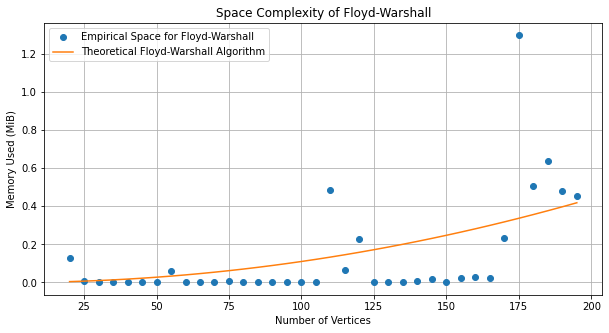

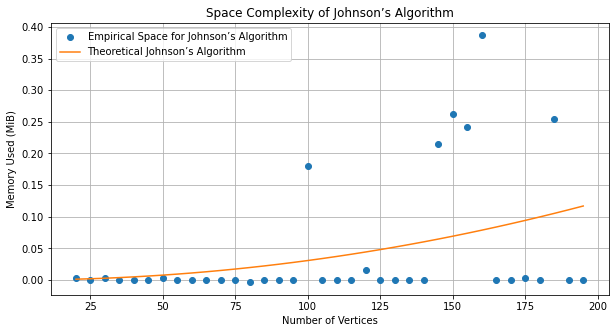

In [23]:
params_fw_space, _ = curve_fit(space_theoretical, sizes, space_fw)
params_johnson_space, _ = curve_fit(space_theoretical, sizes, space_johnson)

# Plot for Floyd-Warshall
plt.figure(figsize=(10, 5))
plt.plot(sizes, space_fw, 'o', label='Empirical Space for Floyd-Warshall')
plt.plot(sizes, space_theoretical(np.array(sizes), *params_fw_space), '-', label='Theoretical Floyd-Warshall Algorithm')
plt.xlabel('Number of Vertices')
plt.ylabel('Memory Used (MiB)')
plt.title('Space Complexity of Floyd-Warshall')
plt.legend()
plt.grid(True)
plt.show()

# Plot for Johnson's
plt.figure(figsize=(10, 5))
plt.plot(sizes, space_johnson, 'o', label='Empirical Space for Johnson’s Algorithm')
plt.plot(sizes, space_theoretical(np.array(sizes), *params_johnson_space), '-', label='Theoretical Johnson’s Algorithm')
plt.xlabel('Number of Vertices')
plt.ylabel('Memory Used (MiB)')
plt.title('Space Complexity of Johnson’s Algorithm')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Doesnt work, probably because of the function or smth, even averaging didnt help